In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
def get_data(start_date, end_date, tickers):
    """
    Fetches the close prices for the specified tickers and calculates the required returns.
    
    Parameters:
    - start_date: The start date for fetching data.
    - end_date: The end date for fetching data.
    - tickers: A list of ticker symbols to download.
    
    Returns:
    - data_df: A DataFrame with close prices and calculated returns.
    """

    # Fetch the data
    data_df = yf.download(tickers, start=start_date, end=end_date, interval="1d")

    # Extract only the Close prices and rename them
    data_df = data_df['Close'][['^GSPC', 'VGSH', 'UPRO', 'SPY']]
    data_df.columns = ['S&P 500 Close', 'VGSH Close', 'UPRO Close', 'SPY Close']

    # Calculate the daily returns. UPRO approximates 2.83x S&P return
    data_df['S&P Returns'] = data_df['S&P 500 Close'].pct_change()
    data_df['Theoretical UPRO Returns'] = data_df['S&P Returns'] * 2.83

    # Calculate the UPRO, VGSH, and SPY returns
    data_df['Actual UPRO Returns'] = data_df['UPRO Close'].pct_change()
    vgsh_daily_return = 0.00434 / 100  # Convert to decimal
    data_df['Theoretical VGSH Returns'] = vgsh_daily_return
    data_df['Actual VGSH Returns'] = data_df['VGSH Close'].pct_change()
    data_df['SPY Returns'] = data_df['SPY Close'].pct_change()

    # Reorder the columns as specified
    data_df = data_df[['S&P 500 Close', 'VGSH Close', 'UPRO Close', 'SPY Close', 'S&P Returns', 'Theoretical UPRO Returns', 
                'Actual UPRO Returns', 'Theoretical VGSH Returns', 'Actual VGSH Returns', 'SPY Returns']]

    # Create the consolidated returns for UPRO and VGSH
    data_df['Consol UPRO Returns'] = data_df['Theoretical UPRO Returns'].where(data_df.index <= '2009-06-25', data_df['Actual UPRO Returns'])
    data_df['Consol VGSH Returns'] = data_df['Theoretical VGSH Returns'].where(data_df.index <= '2009-11-23', data_df['Actual VGSH Returns'])

    return data_df


def calculate_vol_managed_strategy(data_df, lookback_period, risk_off=0.2, risk_on=0.2, initial_value=100.0):
    data = data_df.copy()

    # Calculate the daily returns and volatility
    data['S&P-Daily-Returns'] = data['S&P Returns']
    data['VGSH-Daily-Returns'] = data['Consol VGSH Returns']
    data['UPRO-Daily-Returns'] = data['Consol UPRO Returns']
    data['S&P-Volatility'] = data['S&P-Daily-Returns'].rolling(window=lookback_period).std() * np.sqrt(252)

    # Initialize strategy status and value columns
    strategy_data = pd.DataFrame(index=data.index)
    strategy_data['Vol-Managed Status'] = 'UPRO'  # Start with UPRO
    strategy_data['Vol-Managed Value'] = initial_value

    # Iterate over the dataframe to apply the strategy logic
    for i in range(1, len(strategy_data)):
        current_volatility = data.loc[data.index[i], 'S&P-Volatility']
        previous_strategy = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Status']

        if previous_strategy == 'UPRO' and current_volatility >= risk_off:
            strategy_data.loc[strategy_data.index[i:], 'Vol-Managed Status'] = 'VGSH'
        elif previous_strategy == 'VGSH' and current_volatility <= risk_on:
            strategy_data.loc[strategy_data.index[i:], 'Vol-Managed Status'] = 'UPRO'

        current_strategy = strategy_data.loc[strategy_data.index[i], 'Vol-Managed Status']

        # Update value based on returns and transaction fees
        if current_strategy != previous_strategy:
            fee = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Value'] * 0.002
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Value'] - fee
        else:
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] = strategy_data.loc[strategy_data.index[i-1], 'Vol-Managed Value']

        if current_strategy == 'UPRO':
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] *= (1 + data.loc[data.index[i], 'UPRO-Daily-Returns'])
        else:
            strategy_data.loc[strategy_data.index[i], 'Vol-Managed Value'] *= (1 + data.loc[data.index[i], 'VGSH-Daily-Returns'])

    # Calculate daily returns for the strategy
    strategy_data['Vol-Managed Returns'] = strategy_data['Vol-Managed Value'].pct_change()

    return strategy_data


def calculate_snp_buy_and_hold_strategy(data_df, initial_value=100.0):
    data = data_df.copy()

    # Initialize a DataFrame for the strategy
    strategy_data = pd.DataFrame(index=data.index)
    strategy_data['S&P Buy and Hold'] = initial_value

    # Calculate the value of the strategy over time
    for i in range(1, len(strategy_data)):
        strategy_data.loc[strategy_data.index[i], 'S&P Buy and Hold'] = strategy_data.loc[strategy_data.index[i-1], 'S&P Buy and Hold'] * (1 + data.loc[data.index[i], 'S&P Returns'])

    # Calculate daily returns for the strategy
    strategy_data['S&P Returns'] = strategy_data['S&P Buy and Hold'].pct_change()

    return strategy_data


def calculate_upro_buy_and_hold_strategy(data_df, initial_value=100.0):
    data = data_df.copy()

    # Initialize a DataFrame for the strategy
    strategy_data = pd.DataFrame(index=data.index)
    strategy_data['UPRO Buy and Hold'] = initial_value

    # Calculate the value of the strategy over time
    for i in range(1, len(strategy_data)):
        strategy_data.loc[strategy_data.index[i], 'UPRO Buy and Hold'] = strategy_data.loc[strategy_data.index[i-1], 'UPRO Buy and Hold'] * (1 + data.loc[data.index[i], 'Consol UPRO Returns'])

    # Calculate daily returns for the strategy
    strategy_data['UPRO Returns'] = strategy_data['UPRO Buy and Hold'].pct_change()

    return strategy_data


def calculate_rotation_strategy(data_df, upro_ath=1.88, sp500_ath=1104, risk_on_percentage=19):
    """
    Calculate the rotation strategy based on the UPRO and S&P 500 ATHs and the risk_on_percentage.
    
    Parameters:
    - data_df: pandas DataFrame containing the UPRO and S&P 500 data.
    - upro_ath: Starting all-time high of UPRO. Default is 2.17.
    - sp500_ath: Starting all-time high of the S&P 500. Default is 1565.15.
    - risk_on_percentage: Percentage drop from the S&P 500 ATH at which to switch back to UPRO. Default is 0.2%.
    
    Returns:
    - strategy_df: DataFrame with the calculated strategy values, returns, and statuses.
    """

    # Initialize columns for the strategy DataFrame
    strategy_df = pd.DataFrame(index=data_df.index)
    strategy_df['Rotation Strategy Value'] = 100.0  # Starting value
    strategy_df['Rotation Status'] = 'UPRO'  # Initial status
    strategy_df['Rotation Returns'] = 0.0

    # Track the all-time highs for S&P 500 and UPRO dynamically
    dynamic_sp500_ath = sp500_ath
    dynamic_upro_ath = upro_ath

    for i in range(1, len(strategy_df)):
        previous_status = strategy_df.iloc[i-1]['Rotation Status']
        current_upro_value = data_df.iloc[i]['UPRO Close']
        current_sp500_value = data_df.iloc[i]['S&P 500 Close']

        # Update the dynamic S&P 500 ATH
        dynamic_sp500_ath = max(dynamic_sp500_ath, current_sp500_value)

        # Update the dynamic UPRO ATH
        dynamic_upro_ath = max(dynamic_upro_ath, current_upro_value)

        # Calculate the dynamic risk-on level based on the updated S&P 500 ATH
        risk_on_level = dynamic_sp500_ath * (1 - risk_on_percentage / 100)

        # If in UPRO and it reaches or exceeds its ATH, switch to SPY
        if current_upro_value >= dynamic_upro_ath:
            strategy_df.iloc[i:, strategy_df.columns.get_loc('Rotation Status')] = 'SPY'
        
        # If in SPY and the S&P 500 drops below the dynamic risk-on level, switch to UPRO
        elif previous_status == 'SPY' and current_sp500_value <= risk_on_level:
            strategy_df.iloc[i:, strategy_df.columns.get_loc('Rotation Status')] = 'UPRO'

        # Update the strategy value based on the current status
        current_status = strategy_df.iloc[i]['Rotation Status']
        if current_status == 'UPRO':
            strategy_df.iloc[i, strategy_df.columns.get_loc('Rotation Strategy Value')] = \
                strategy_df.iloc[i-1]['Rotation Strategy Value'] * (1 + data_df.iloc[i]['Consol UPRO Returns'])
        else:  # current_status == 'SPY'
            strategy_df.iloc[i, strategy_df.columns.get_loc('Rotation Strategy Value')] = \
                strategy_df.iloc[i-1]['Rotation Strategy Value'] * (1 + data_df.iloc[i]['SPY Returns'])

        # Calculate the returns for the current day
        strategy_df.iloc[i, strategy_df.columns.get_loc('Rotation Returns')] = \
            strategy_df.iloc[i]['Rotation Strategy Value'] / strategy_df.iloc[i-1]['Rotation Strategy Value'] - 1

    # Keep only the desired columns
    strategy_df = strategy_df[['Rotation Strategy Value', 'Rotation Status', 'Rotation Returns']]

    return strategy_df


def calculate_investment_metrics(combined_df, strategy_names, risk_free_rate=0.0):
    metrics = {}
    
    # Mapping strategy names to their respective return column names
    return_columns = {
        'Vol-Managed Value': 'Vol-Managed Returns',
        'Rotation Strategy Value': 'Rotation Returns',
        'S&P Buy and Hold': 'S&P Returns',
        'UPRO Buy and Hold': 'UPRO Returns'
    }
    
    for strategy in strategy_names:
        # Use the correct returns column based on the strategy name
        returns_column_name = return_columns.get(strategy)
        cumulative_column_name = strategy
        
        returns = combined_df[returns_column_name].dropna()
        cumulative_values = combined_df[cumulative_column_name]

        # Calculate annualized return and standard deviation
        avg_daily_return = returns.mean()
        annualized_return = avg_daily_return * 252
        std_dev = returns.std() * np.sqrt(252)

        # Calculate Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate) / std_dev

        # Calculate downside deviation for the Sortino ratio
        downside_returns = returns[returns < risk_free_rate]
        downside_std_dev = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_return - risk_free_rate) / downside_std_dev

        # Calculate cumulative return and maximum drawdown
        cumulative_return = (1 + returns).cumprod()
        rolling_max = cumulative_return.cummax()
        drawdown = cumulative_return / rolling_max - 1
        max_drawdown = drawdown.min()

        # Calculate CAGR
        cagr = (cumulative_values.iloc[-1] / cumulative_values.iloc[0]) ** (
            1 / ((cumulative_values.index[-1] - cumulative_values.index[0]).days / 365.25)) - 1

        # Calculate Calmar Ratio
        calmar_ratio = cagr / abs(max_drawdown)

        # Calculate Omega Ratio
        omega_ratio = returns[returns > risk_free_rate].sum() / abs(returns[returns < risk_free_rate].sum())

        # Percentage of profitable days
        profitable_days = (returns > 0).mean() * 100

        # Calculate skewness and kurtosis
        skewness = stats.skew(returns)
        kurtosis = stats.kurtosis(returns)

        # Calculate the number of trades and average days in each state
        if strategy == 'Vol-Managed Value':
            strategy_column = combined_df['Vol-Managed Status']
            strategy_numeric = strategy_column.map({'UPRO': 1, 'VGSH': 0, 'SPY': 2})
            trades = strategy_numeric.diff().abs().sum()

            state_durations = strategy_numeric.groupby((strategy_numeric != strategy_numeric.shift()).cumsum()).transform('size')
            avg_days_upro = state_durations[strategy_numeric == 1].mean()
            avg_days_vgsh = state_durations[strategy_numeric == 0].mean()
            avg_days_spy = state_durations[strategy_numeric == 2].mean() if 2 in strategy_numeric.unique() else 0
        else:
            trades = np.nan
            avg_days_upro = np.nan
            avg_days_vgsh = np.nan
            avg_days_spy = np.nan

        metrics[strategy] = {
            'CAGR': round(cagr * 100, 3),  # Convert to percentage
            'Sharpe Ratio': round(sharpe_ratio, 3),  # Unitless
            'Sortino Ratio': round(sortino_ratio, 3),  # Unitless
            'Standard Deviation': round(std_dev * 100, 3),  # Convert to percentage
            'Downside Deviation': round(downside_std_dev * 100, 3),  # Convert to percentage
            'Maximum Drawdown': round(max_drawdown * 100, 3),  # Convert to percentage
            'Calmar Ratio': round(calmar_ratio * 100, 3),  # Convert to percentage
            'Omega Ratio': round(omega_ratio * 100, 3),  # Convert to percentage
            '% Profitable Days': round(profitable_days, 3),  # Already in percentage
            'Skewness': round(skewness, 3),  # Unitless
            'Kurtosis': round(kurtosis, 3),  # Unitless
            'Number of Trades': int(trades) if pd.notna(trades) else None,
            'Avg Days in UPRO': round(avg_days_upro, 3) if pd.notna(avg_days_upro) else None,
            'Avg Days in VGSH': round(avg_days_vgsh, 3) if pd.notna(avg_days_vgsh) else None,
            'Avg Days in SPY': round(avg_days_spy, 3) if pd.notna(avg_days_spy) else None
        }

    # Convert the metrics dictionary into a DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df  # Keep the columns as strategies without transposing


def plot_investment_values_and_volatility(combined_df, data_df, strategy_names):
    """
    Plots the change in investment value over time for multiple strategies and the 20-day S&P 500 volatility.
    
    Parameters:
    - combined_df: pandas DataFrame containing the investment data.
    - data_df: pandas DataFrame containing the S&P 500 returns data.
    - strategy_names: List of strings representing the column names of the investment strategies.
    """

    # Calculate the 20-day volatility of the S&P 500
    data_df['20-Day Volatility'] = data_df['S&P Returns'].rolling(window=20).std() * (252 ** 0.5)

    # Create a figure with two subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))

    # First subplot: change in investment value over time
    for strategy in strategy_names:
        axs[0].plot(combined_df.index, combined_df[strategy], label=strategy)
    axs[0].set_title('Change in Investment Value Over Time')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Investment Value ($)')
    axs[0].legend()
    axs[0].grid(True)

    # Second subplot: 20-day volatility of S&P 500 over time
    axs[1].plot(data_df.index, data_df['20-Day Volatility'], label='20-Day S&P Volatility', color='red')
    axs[1].set_title('20-Day S&P Volatility Over Time')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('20-Day Volatility')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_returns_distribution(returns, bins=50, title="Distribution of Returns"):

    # Convert returns to a pandas Series if not already one
    if not isinstance(returns, pd.Series):
        returns = pd.Series(returns)

    # Create the distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(returns, bins=bins, kde=True, color='blue')

    # Add labels and title
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True)

    # Show the plot
    plt.show()

In [3]:
# Start and end dates
start_date = '2010-01-01'
end_date = '2024-09-29'

# Fetch historical data for the S&P 500, VGSH, and UPRO
tickers = ['^GSPC', 'VGSH', 'UPRO', 'SPY']
data_df = get_data(start_date, end_date, tickers)

# Define lookback period and volatility upper threshold
lookback_period = 20
risk_off = 0.2
risk_on = 0.2

# Calculate each strategy
vol_managed_df = calculate_vol_managed_strategy(data_df, lookback_period, risk_off, risk_on)
snp_buy_and_hold_df = calculate_snp_buy_and_hold_strategy(data_df)
upro_buy_and_hold_df = calculate_upro_buy_and_hold_strategy(data_df)
rotation_strategy = calculate_rotation_strategy(data_df, upro_ath=1.88, sp500_ath=1104, risk_on_percentage=19)

# Concatenate all strategy data
combined_df = pd.concat([vol_managed_df, snp_buy_and_hold_df, upro_buy_and_hold_df, rotation_strategy], axis=1)

# Add the closing prices of S&P 500, VGSH, UPRO, and SPY to the combined_df
combined_df['S&P 500 Close'] = data_df['S&P 500 Close']
combined_df['VGSH Close'] = data_df['VGSH Close']
combined_df['UPRO Close'] = data_df['UPRO Close']
combined_df['SPY Close'] = data_df['SPY Close']

# Display the last few rows of the combined dataframe
combined_df.tail()

[*********************100%%**********************]  4 of 4 completed


,Vol-Managed Status,Vol-Managed Value,Vol-Managed Returns,S&P Buy and Hold,S&P Returns,UPRO Buy and Hold,UPRO Returns,Rotation Strategy Value,Rotation Status,Rotation Returns,S&P 500 Close,VGSH Close,UPRO Close,SPY Close
Date,,,,,,,,,,,,,,
2024-09-23,UPRO,6459.459060,0.007736,504.732599,0.002809,3852.283720,0.007736,2014.191429,SPY,0.002499,5718.569824,59.070000,84.669998,569.669983
2024-09-24,UPRO,6514.387824,0.008504,506.000073,0.002511,3885.042064,0.008504,2019.954663,SPY,0.002861,5732.930176,59.130001,85.389999,571.299988
2024-09-25,UPRO,6450.304654,-0.009837,505.058281,-0.001861,3846.824227,-0.009837,2015.499626,SPY,-0.002206,5722.259766,59.080002,84.550003,570.039978
2024-09-26,UPRO,6528.120016,0.012064,507.098047,0.004039,3893.231651,0.012064,2023.490380,SPY,0.003965,5745.370117,59.029999,85.570000,572.299988
2024-09-27,UPRO,6491.500645,-0.005609,506.462543,-0.001253,3871.392638,-0.005609,2020.555675,SPY,-0.001450,5738.169922,59.110001,85.089996,571.469971


In [4]:
strategy_names = ['Vol-Managed Value', 'Rotation Strategy Value', 'S&P Buy and Hold', 'UPRO Buy and Hold']
metrics_df = calculate_investment_metrics(combined_df, strategy_names)
metrics_df

,Vol-Managed Value,Rotation Strategy Value,S&P Buy and Hold,UPRO Buy and Hold
CAGR,32.752,22.639,11.643,28.174
Sharpe Ratio,1.022,0.753,0.724,0.745
Sortino Ratio,1.265,0.852,0.890,0.912
Standard Deviation,33.175,35.836,17.306,51.483
Downside Deviation,26.802,31.653,14.075,42.050
Maximum Drawdown,-37.874,-66.044,-33.925,-76.817
Calmar Ratio,86.476,34.279,34.320,36.677
Omega Ratio,121.264,119.802,114.743,115.203
% Profitable Days,52.670,54.651,54.450,54.531
Skewness,-0.466,-0.382,-0.490,-0.507


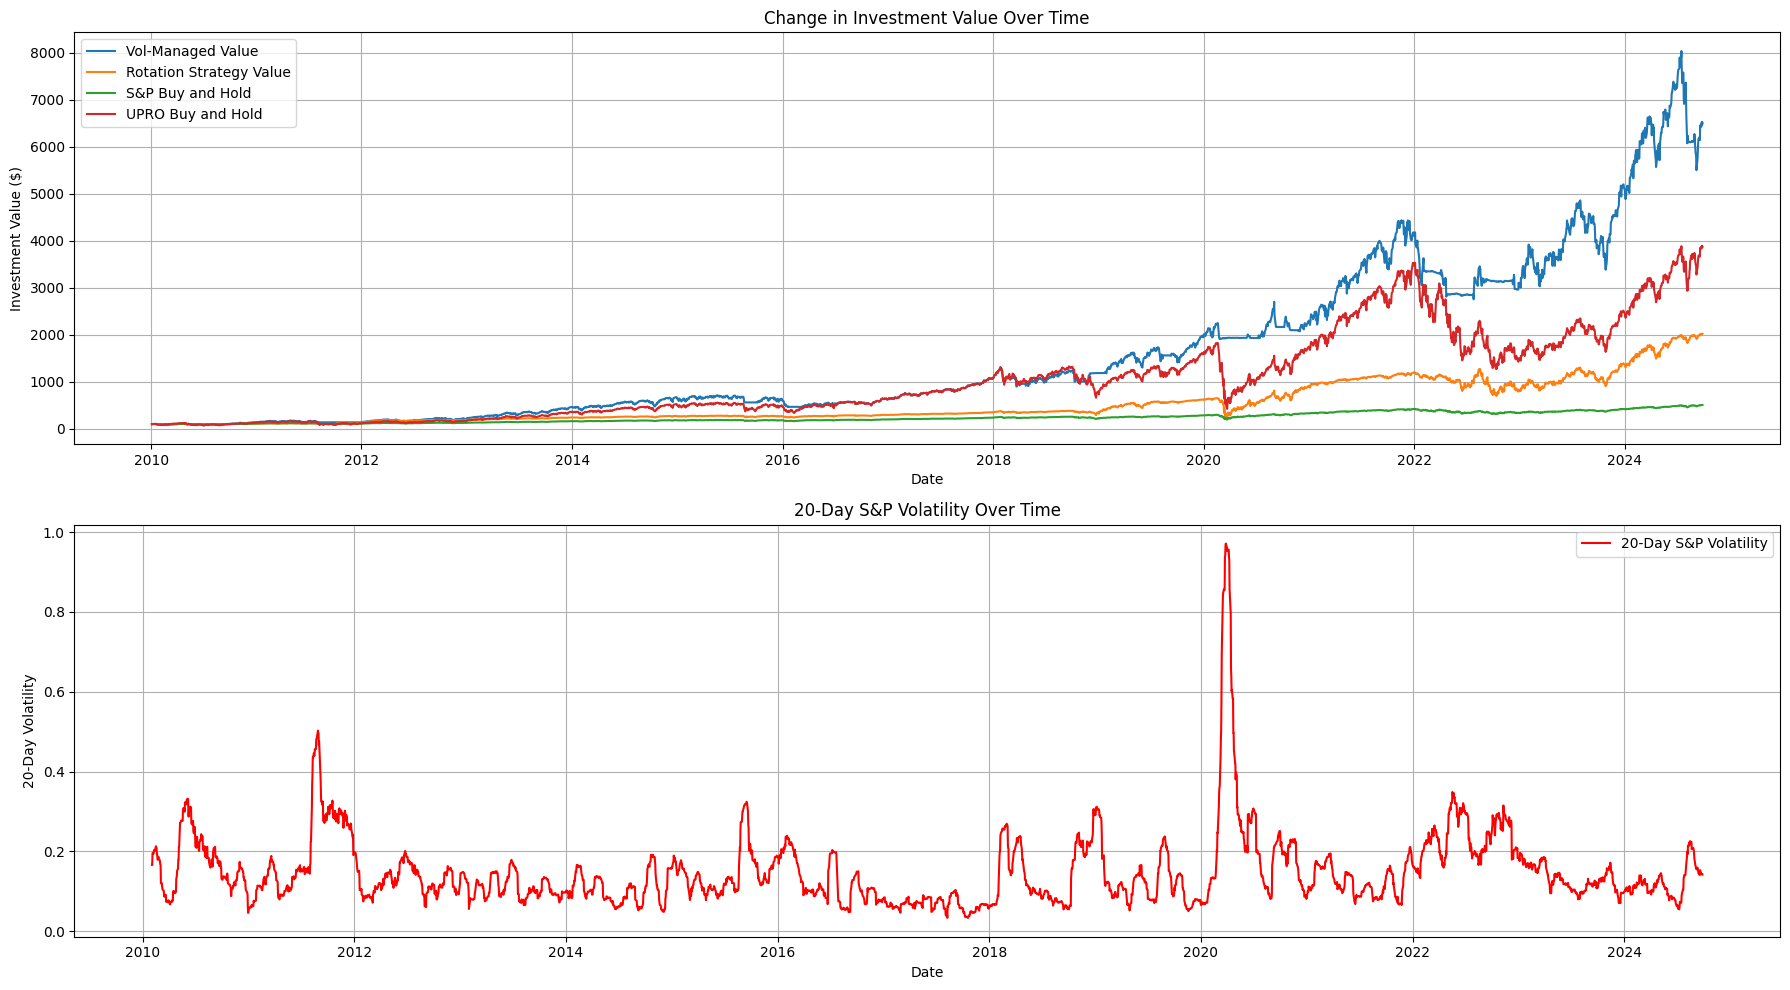

In [5]:
# Example usage:
strategy_names = ['Vol-Managed Value', 'Rotation Strategy Value', 'S&P Buy and Hold', 'UPRO Buy and Hold']
plot_investment_values_and_volatility(combined_df, data_df, strategy_names)

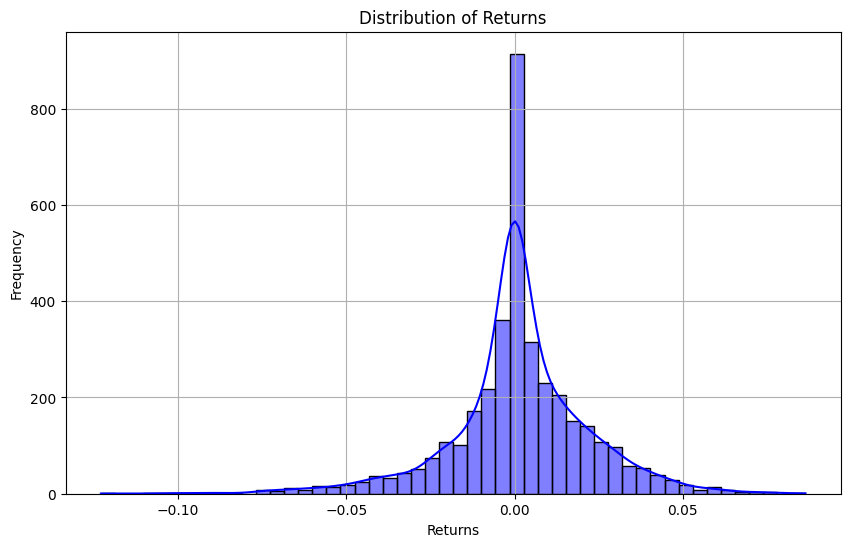

In [6]:
plot_returns_distribution(combined_df["Vol-Managed Returns"])